## 24 - Esteganografia

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
!wget https://raw.githubusercontent.com/wlcosta/es235_pdi/master/utils/pokebola.jpg
!wget https://raw.githubusercontent.com/wlcosta/es235_pdi/master/utils/charizard.jpeg

--2021-07-21 22:07:11--  https://raw.githubusercontent.com/wlcosta/es235_pdi/master/utils/pokebola.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90629 (89K) [image/jpeg]
Saving to: ‘pokebola.jpg’

pokebola.jpg        100%[===================>]  88.50K  --.-KB/s    in 0.005s  

2021-07-21 22:07:11 (16.3 MB/s) - ‘pokebola.jpg’ saved [90629/90629]

--2021-07-21 22:07:11--  https://raw.githubusercontent.com/wlcosta/es235_pdi/master/utils/charizard.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53685 (52K) [image/jpeg]
Savi

In [243]:
source = Image.open('pokebola.jpg')
img_to_hidden = Image.open('charizard.jpeg')

Antes de aplicar o processo de esteganografia, vamos visualizar as duas imagens

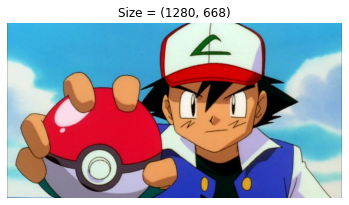

In [244]:
fig = plt.Figure()
plt.imshow(np.asarray(source))
plt.axis(False)
plt.title(f'Size = {source.size}')

for txt in fig.texts:
    txt.set_visible(False)

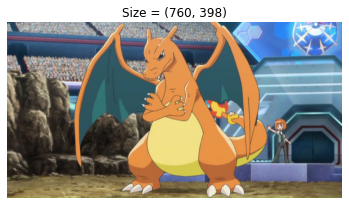

In [245]:
fig = plt.Figure()
plt.imshow(np.asarray(img_to_hidden))
plt.axis(False)
plt.title(f'Size = {img_to_hidden.size}')

for txt in fig.texts:
    txt.set_visible(False)

### 24.1 Escondendo uma imagem

Para ocultar uma imagem dentro de outra, a imagem que ficará escondida deve ter, no máximo, o mesmo tamanho da imagem que a ocultará.

In [246]:
# Checar o tamanho das imagens
if img_to_hidden.size[0] > source.size[0] or img_to_hidden.size[1] > source.size[1]:
    raise ValueError('A imagem para ser escondida deve ser menor do que a imagem fonte')

Os seguintes métodos serão mais a frente, para converter valores decimais em binários e vice-versa:

In [247]:
def int_to_bin(rgb):
    r, g, b = rgb
    return ('{0:08b}'.format(r),
            '{0:08b}'.format(g),
            '{0:08b}'.format(b))
    
def bin_to_int(rgb):
    r, g, b = rgb
    return (int(r, base=2),
            int(g, base=2),
            int(b, base=2))

Antes de partir para o algoritmo, precisamos definir uma de realizar a mesclagem (merge) entre as duas imagens. Para isto, a seguinte função juntará os bits mais significativos da imagem 1 com os bits mais significativos da imagem 2:

In [248]:
def merge_rgb(rgb1, rgb2):
    r1, g1, b1 = rgb1
    r2, g2, b2 = rgb2
    rgb = (r1[:4] + r2[:4],
            g1[:4] + g2[:4],
            b1[:4] + b2[:4])
    return rgb

Finalmente, devemos criar dois loops para percorrer todos os pixels das imagens. Em seguida, obtemos o RGB da imagem 1 e da imagem 2 como valores binários e realizamos o merge.

In [249]:
def merge(source, img_to_hidden):
    # Checar o tamanho das imagens
    if img_to_hidden.size[0] > source.size[0] or img_to_hidden.size[1] > source.size[1]:
        raise ValueError('A imagem para ser escondida deve ser menor do que a imagem fonte')

    # Pegar o mapa de pixels das imagens
    pixels_source = source.load()
    pixels_hidden = img_to_hidden.load()

    # Criar uma nova imagem para o merge
    output = Image.new(source.mode, source.size)
    pixels_out = output.load()

    for i in range(source.size[0]):
        for j in range(source.size[1]):
            # Converter de inteiro para binario
            rgb_source = int_to_bin(pixels_source[i, j])
            # Esta linha será útil para separar as duas imagens (como veremos a seguir)
            rgb_hidden = int_to_bin((0, 0, 0))

            if i < img_to_hidden.size[0] and j < img_to_hidden.size[1]:
                rgb_hidden = int_to_bin(pixels_hidden[i, j])

            rgb = merge_rgb(rgb_source, rgb_hidden)

            pixels_out[i, j] = bin_to_int(rgb)

    return output

In [250]:
output = merge(source, img_to_hidden)

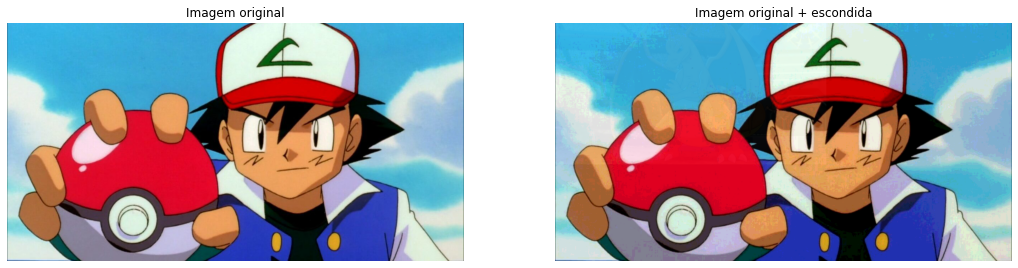

In [251]:
fig, axs = plt.subplots(1,2, figsize=(18,18))
axs[0].imshow(np.asarray(source))
axs[1].imshow(np.asarray(output))
axs[0].axis(False)
axs[1].axis(False)
axs[0].set_title('Imagem original')
axs[1].set_title('Imagem original + escondida')

for txt in fig.texts:
    txt.set_visible(False)

### 24.2 Revelando uma imagem

Para revelar uma imagem, devemos saber quantos bits foram usados para ocultar a imagem. Nesse caso, estamos usando um número fixo de 4 bits. As mesmas funções de conversão usadas anteriormente serão necessárias aqui tambem.

In [252]:
def unmerge(img):
    # Carregar o mapa de pixels da imagem
    pixel_map = img.load()

    # Criar uma nova imagem e carregar o seu mapa de pixels
    output = Image.new(img.mode, img.size)
    pixels_out = output.load()

    # Tupla usada para guardar o tamanho da imagem original
    original_size = img.size

    for i in range(img.size[0]):
        for j in range(img.size[1]):
            # Conversão de inteiro para binário
            r, g, b = int_to_bin(pixel_map[i, j])

            rgb = (r[4:] + '0000',
                    g[4:] + '0000',
                    b[4:] + '0000')

            # Convert it to an integer tuple
            pixels_out[i, j] = bin_to_int(rgb)

            # If this is a 'valid' position, store it
            # as the last valid position
            if pixels_out[i, j] != (0, 0, 0):
                original_size = (i + 1, j + 1)

    # Crop the image based on the 'valid' pixels
    output = output.crop((0, 0, original_size[0], original_size[1]))

    return output

Como podemos observar na parte:
```
rgb = (r[4:] + '0000',
       g[4:] + '0000',
       b[4:] + '0000')
```

Estamos extraindo os 4 bits mais a direita e concatenando com 4 zeros, já que a imagem é de 8 bits.

In [253]:
hidden_img = unmerge(output)

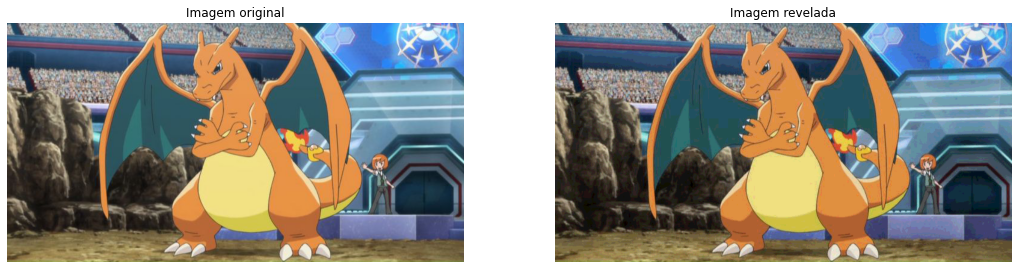

In [254]:
fig, axs = plt.subplots(1,2, figsize=(18,18))
axs[0].imshow(np.asarray(img_to_hidden))
axs[1].imshow(np.asarray(test))
axs[0].axis(False)
axs[1].axis(False)
axs[0].set_title('Imagem original')
axs[1].set_title('Imagem revelada')

for txt in fig.texts:
    txt.set_visible(False)